In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error
from data_processing import generate_data, lstm_model, load_csvdata
from pymongo import MongoClient
from bson.objectid import ObjectId
import dateutil.parser
import datetime
import matplotlib.dates as mdates

In [2]:
LOG_DIR = './ops_logs/train'
TIMESTEPS = 10
RNN_LAYERS = [{'num_units': 5}]
DENSE_LAYERS = [10, 10]
TRAINING_STEPS = 5000
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 100

In [3]:
def load_data(filename):
    df = pd.read_csv(filename, names=["date", "in_id", "out_id", "calls", "duration"], parse_dates=['date'])
    df = df['calls'].groupby(df.date).sum()
    df = df.reset_index()
    df = df.set_index("date")
    
    return df
data = load_data("data/exo1_bs2.csv")

In [4]:
X, y = load_csvdata(data, TIMESTEPS, seperate=False)

In [41]:
regressor = tf.contrib.learn.TensorFlowRNNRegressor(100)
# create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                     every_n_steps=PRINT_STEPS,
                                                     early_stopping_rounds=1000)
regressor.fit(X['train'], y['train'],
              monitors=[validation_monitor],
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

predicted = regressor.predict(X['test'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'save_summary_steps': 100, '_num_ps_replicas': 0, '_task_type': None, '_environment': 'local', '_is_chief': True, 'save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x103bde250>, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, 'tf_random_seed': None, 'keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', 'save_checkpoints_steps': None, '_master': '', 'keep_checkpoint_max': 5}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Sc

KeyboardInterrupt: 

In [38]:
#not used in this example but used for seeing deviations
preds = regressor.predict(X['test'])
print(preds)
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))

score = mean_squared_error(predicted, y['test'])
print ("MSE: ", score)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
<generator object _infer_model_as_iterable at 0x124912780>


TypeError: unsupported operand type(s) for -: 'generator' and 'float'

AttributeError: 'generator' object has no attribute 'flatten'

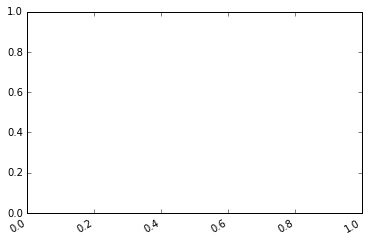

In [33]:
# plot the data
all_dates = data.index.get_values()

fig, ax = plt.subplots(1)
fig.autofmt_xdate()

predicted_values = predicted.flatten() #already subset
predicted_dates = all_dates[len(all_dates)-len(predicted_values):len(all_dates)]
predicted_series = pd.Series(predicted_values, index=predicted_dates)
plot_predicted, = ax.plot(predicted_series, label='predicted (c)')

test_values = y['test'].flatten()
test_dates = all_dates[len(all_dates)-len(test_values):len(all_dates)]
test_series = pd.Series(test_values, index=test_dates)
plot_test, = ax.plot(test_series, label='2015 (c)')

xfmt = mdates.DateFormatter('%b %d %H')
ax.xaxis.set_major_formatter(xfmt)

# ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d %H')
plt.title('PDX Weather Predictions for 2016 vs 2015')
plt.legend(handles=[plot_predicted, plot_test])
plt.show()